# Assignment 3: Edges and Hough transform

### Exercise 1: Image derivatives

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import a3_utils

a) Follow the equations above and derive the equations used to compute first and second derivatives with respect to y: Iy(x,y), Iyy(x,y); as well as the mixed derivative Ixy(x,y)

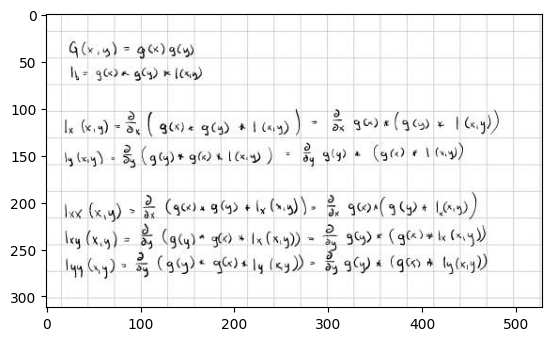

In [3]:
# Add image
img = cv2.imread("1a.jpg")
plt.imshow(img)

b) Implement a function that computes the derivative of a 1D Gaussian kernel. The formula for the derivative of the Gaussian kernel is: \
`d/dx g(x) = d/dx (1/sqrt(2pi)*sigma) * e^(-x^2/2*sigma^2) = \
-(1/sqrt(2pi) * sigma^3) * xe(-x^2/2*sigma^2)` \

Implement the function `gaussdx(sigma)` that works the same as the function `gauss` from the previous assignment. Don't forget to normalize the kernel. Be careful as the derivative is an odd function, so a simple sum will not do. Instead normalize the kernel by dividing hte values such that the sum of absoulte values is 1. Effectively you have to divide each value by sum(abs(gx(x)))

In [4]:
def normalize(xs):
    res = [abs(x) for x in xs]
    return xs / np.sum(res)
    

def gaussdx(sigma):
    return np.array(normalize([(-1/(np.sqrt(2 * np.pi) * sigma**3)) * x * np.exp(-x**2 / (2 * sigma**2)) for x in np.arange(-np.ceil(3*sigma), np.ceil(3*sigma)+1, 1)]))

1.0


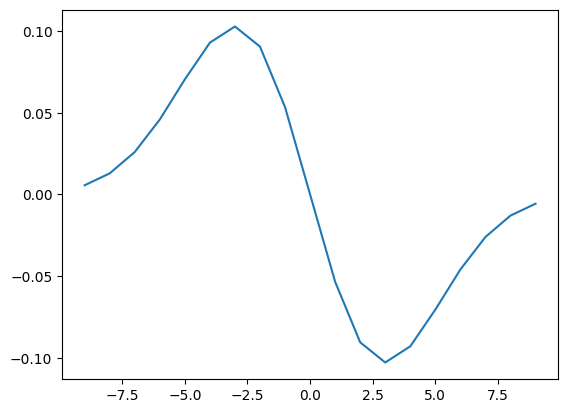

In [5]:
# Test
print(sum(np.abs(gaussdx(3))))
plt.plot([x for x in np.arange(-np.ceil(3*3), np.ceil(3*3)+1, 1)], gaussdx(3))

c) The properties of the filter can be analyzed by usin an `impulse response function`. This is performed as a convolution of the filter with a Dirac delta function. The discrete version of the Dirac function is constructed as a finite image that has all elements set to 0 except the central element, which is set to a high value. \
Generate a 1D Gaussian kernel G and a Gaussian derivative kernel D. What happens if you apply the following operations to the impulse image?  
*    Impulse * G * G.T 
*    Impulse * G * D.T 
*    Impulse * D * G.T 
*    Impulse * G.T * D 
*    Impulse * D.T * G 

Is the order of operations important? Display the images of the impulse responses for different combinations of operations.

In [6]:
def gaussian_kernel(sigma):
    return np.array([1 / (np.sqrt(2*np.pi) * sigma) * np.exp((-np.square(x)) / (2 * np.square(sigma))) for x in np.arange(-np.ceil(3*sigma), np.ceil(3*sigma)+1, 1)])

In [263]:
sigma = 3
GT = gaussian_kernel(sigma)
G = np.reshape(GT, (1, -1))
DT = gaussdx(sigma)[::-1]
D = np.reshape(DT, (1, -1))
#plt.plot([x for x in np.arange(-np.ceil(3*3), np.ceil(3*3)+1, 1)], D)

impulse = np.zeros((50,50))
impulse[25,25] = 1

# a
ggt = cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, GT)

#b
gdt = cv2.filter2D(cv2.filter2D(impulse, -1, G), -1, DT)

#c
dgt = cv2.filter2D(cv2.filter2D(impulse, -1, D), -1, GT)

#d
gtd = cv2.filter2D(cv2.filter2D(impulse, -1, GT), -1, D)

#e
dtg = cv2.filter2D(cv2.filter2D(impulse, -1, DT), -1, G)

#fig, ax = plt.subplots(2,3,figsize=(10,7))

#ax[0][0].imshow(impulse, cmap="gray")
#ax[0][1].imshow(gdt, cmap="gray")
#ax[0][2].imshow(dgt, cmap="gray")
#ax[1][0].imshow(ggt, cmap="gray")
#ax[1][1].imshow(gtd, cmap="gray")
#ax[1][2].imshow(dtg, cmap="gray")
#ax[0][0].set_title("impulse")
#ax[0][1].set_title("G * D.T")
#ax[0][2].set_title("D * G.T")
#ax[1][0].set_title("G * G.T")
#ax[1][1].set_title("G.T * D")
#ax[1][2].set_title("D.T * G")


No, the order of operations doesn't matter as convolution is commutative.

d) Implement a function that uses functions `gauss` and `gaussdx` to compute both
partial derivatives of a given image with respect to x and with respect to y. \
Similarly, implement a function that returns partial second order derivatives of a
given image.
Additionally, implement the function `gradient_magnitude` that accepts a grayscale
image I and returns both derivative magnitudes and derivative angles. Magnitude is calculated as
`m(x,y) = sqrt(Ix(x,y)^2 + Iy(x,y)^2)`
 and angles are calculated as
`φ(x,y) = arctan(Iy(x, y)/Ix(x, y))`
Hint: Use function `np.arctan2` to avoid division by zero for calculating the arctangent function.
Use all the implemented functions on the same image and display the results in the
same window.

In [8]:
def derive_1(img, sigma):
    img = img.astype(np.float64)

    gx = gaussian_kernel(sigma)
    gy = np.reshape(gx, (1, -1))
    
    d_gx = gaussdx(sigma)
    d_gy = np.reshape(d_gx, (1, -1))
    
    # switch x and y because filter2D will use (256, ) shape as (1, 256)
    gx, gy, d_gx, d_gy = gy, gx, d_gy, d_gx
    
    dx_img = cv2.filter2D(cv2.filter2D(img, -1, gy), -1, d_gx)
    dy_img = cv2.filter2D(cv2.filter2D(img, -1, gx), -1, d_gy)
    
    return dx_img, dy_img

def derive_2(img, sigma):
    #img = img.astype(np.float64)
    gx = gaussian_kernel(sigma)
    gy = np.reshape(gx, (1, -1))
    
    d_gx = gaussdx(sigma)
    d_gy = np.reshape(d_gx, (1, -1))
    
    dx_img, dy_img = derive_1(img, sigma)
    
    # switch x and y because filter2D will use (256, ) shape as (1, 256)
    dxx_img = cv2.filter2D(cv2.filter2D(dx_img, -1, gx), -1, d_gy)
    dxy_img = cv2.filter2D(cv2.filter2D(dx_img, -1, gy), -1, d_gx)
    dyy_img = cv2.filter2D(cv2.filter2D(dy_img, -1, gx), -1, d_gy)
    
    return dxx_img, dxy_img, dyy_img

def gradient_magnitude(img):
    Ix, Iy = derive_1(img, sigma)
    magnitude = np.sqrt(np.square(Ix) + np.square(Iy))
    angles = np.arctan2(Iy, Ix) 
    return magnitude, angles
    

In [264]:
img = cv2.imread("images/museum.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sigma=1

Ix, Iy = derive_1(img, sigma)
Ixx, Ixy, Iyy = derive_2(img, sigma)
mag, ang = gradient_magnitude(img)

#fig, ax = plt.subplots(2,4,figsize=(12,5))
#
#ax[0,0].imshow(img, cmap="gray")
#ax[0,1].imshow(Ix, cmap="gray")
#ax[0,2].imshow(Iy, cmap="gray")
#ax[0,3].imshow(mag, cmap="gray")
#ax[1,0].imshow(Ixx, cmap="gray")
#ax[1,1].imshow(Ixy, cmap="gray")
#ax[1,2].imshow(Iyy, cmap="gray")
#ax[1,3].imshow(ang, cmap="gray")
#
#ax[0,0].set_title("Original")
#ax[0,1].set_title("I_x")
#ax[0,2].set_title("I_y")
#ax[0,3].set_title("I_mag")
#ax[1,0].set_title("I_xx")
#ax[1,1].set_title("I_xy")
#ax[1,2].set_title("I_yy")
#ax[1,3].set_title("I_dir")


e) (15) Gradient information is often used in image recognition. Extend your image retrieval system from the previous assignment to use a simple gradient-based feature instead of color histograms. To calculate this feature, compute gradient magnitudes and angles for the entire image, then divide the image in a 8 × 8 grid.
For each cell of the grid compute a 8 bin histogram of gradient magnitudes with respect to gradient angle (quantize the angles into 8 values, then for each pixel of the cell, add the value of the gradient to the bin specified by the corresponding angle). Combine all the histograms to get a single 1-D feature for every image. Test
the new feature on the image database from the previous assignment. Compare the new results to the color histogram based retrieval.

### Exercise 2: Edges in images
One of the most widely used edge detector algorithms is Canny edge detector. In this exercise you will implements parts of Canny's algorithm

a) Firstly create a function `findedges` that accepts an image `I`, and the parameters `sigma` and `theta`. \
The function should create a binary matrix `Ie` that only keeps pixels higher than threshold `theta`. \
Test the function with the image `museum.png` and display the results for different values of the parameter `theta`. Can you set the parameter so that all the edges in the image are clearly visible?

In [10]:
def findedges(img, sigma, theta):
    # Smoothe the image
    img = img.astype(np.float64)/255
    #img = cv2.filter2D(img, -1, gaussian_kernel(sigma))
    print(np.mean(img))
    
    # Threshold
    mask = np.where(img > theta, 1, 0)
    
    return mask 

In [265]:
#fig, ax = plt.subplots(1,2, figsize=(10,6))
#img_edges = findedges(mag, 1, .16).astype(np.float64)
#
#ax[0].imshow(img, cmap="gray")
#ax[1].imshow(img_edges, cmap="gray")
# We cannot clearly expose all the edges

b) Using magnitude produces only a first approximation of detected edges. Unfortunately, these are often wide and we would like to only return edges one pixel wide. Therefore, you will implement non-maxima suppression based on the image derivative magnitudes and angles. Iterate through all the pixels and for each search its 8-neighborhood. Check the neighboring pixels parallel to the gradient direction and set the current pixel to 0 if it is not the largest in the neighborhood (based on derivative magnitude). You only need to compute the comparison to actual pixels,
interpolating to more accuracy is not required.

In [12]:
def non_maxima_suppression(mag, dir):
    img = mag        
    res = np.zeros((img.shape[0], img.shape[1]))
    
    for i in range(img.shape[0]-1):
        for j in range(img.shape[1]-1):

            degrees = dir[i,j] * 180 / np.pi
            if (degrees < 0):
                degrees += 180

            px1, px2 = 0, 0

            if (0 <= degrees < 22.5) or (157.5 <= degrees <= 180):
                px1 = img[i,j+1]
                px2 = img[i,j-1]
            elif 22.5 <= degrees  < 67.5:
                px1 = img[i-1, j-1]
                px2 = img[i+1, j+1]
            elif 67.5 <= degrees < 112.5:
                px1 = img[i-1, j]
                px2 = img[i+1, j]
            elif 112.5 <= degrees < 157.5:
                px1 = img[i+1, j-1]
                px2 = img[i-1, j+1]
            
            if np.max([px1, px2, img[i,j]]) == img[i,j]:
                res[i,j] = img[i,j]
            
           
    return res

0.034825427689104314


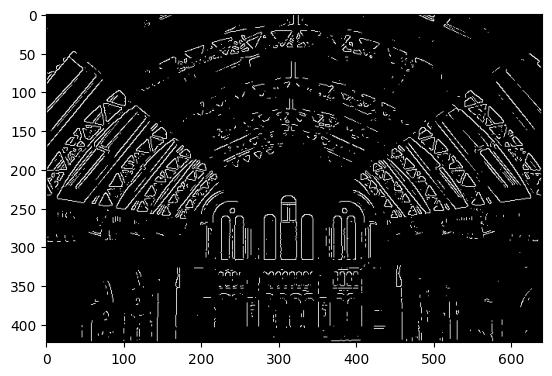

In [13]:
img_suppressed = non_maxima_suppression(mag, ang)
filtered = findedges(img_suppressed, sigma, 0.16)
plt.imshow(filtered, cmap="gray")

c) The final step of Canny's algorithm is edge tracking by hysteresis. Add the final step after performing non-maxima suppression along edges. Hysteresis uses two thresholds t low < t high , keeps all pixels above t high and discards all pixels below t_low . The pixels between the thresholds are kept only if they are connected to
a pixel above t high. \
Hint: Since we are looking for connected components containing at least one pixel above t_high , you could use something like cv2.connectedComponentsWithStats to extract them. Try to avoid explicit for loops as much as possible.

In [14]:
def hysteresis(img, t_low, t_high):
    t_low = t_low * np.max(img)
    t_high = t_high * np.max(img)
    img = img.astype(np.uint8)
    img = np.where(img >= t_low, img, 0)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img)
    
    vals = []
    
    for i in range(num_labels):
        if np.max(img[labels == i]) > t_high:
            vals.append(np.max(img[labels == i]))
            img[labels == i] = 1
        else:
            img[labels == i] = 0
        
    print(np.mean(vals))
    print(np.mean(img))
    
            
    return img

In [266]:
hyst = hysteresis(img_suppressed, .1, .2)

#fig, ax = plt.subplots(2,2,figsize=(10,7))
#
#ax[0,0].imshow(img_suppressed, cmap="gray")
#ax[0,0].set_title("Original")
#ax[0,1].imshow(img_edges, cmap="gray")
#ax[0,1].set_title(f"Thresholded (thr = 0.1)")
#
#ax[1,0].imshow(filtered, cmap="gray")
#ax[1,0].set_title("Nonmax. supp.")
#
#ax[1,1].imshow(hyst, cmap="gray")
#ax[1,1].set_title("Hysteresis")
#

47.48822927328557
0.21244459219858156


### Exercise 3: Detecting lines

Q: Analytically solve the problem by using Hough transform: In 2D space
you are given four points (0, 0), (1, 1), (1, 0), (2, 2). Define the equations of the lines that run through at least two of these points.


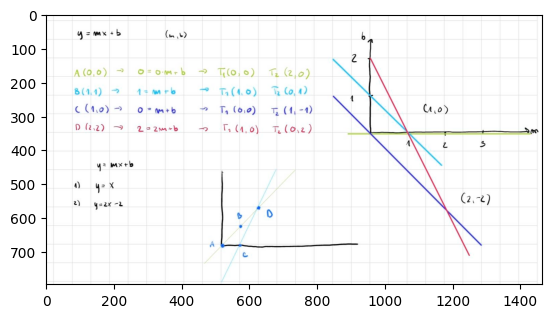

In [16]:
res = cv2.imread("3a.jpg")
plt.imshow(res)

a) Create an accumulator array defined by the resolution on ρ and ϑ values. Calculate the sinusoid that represents all the lines that pass through some nonzero point. Increment the corresponding cells in the accumulator array. Experiment with different positions of the nonzero point to see how the sinusoid changes. You can set the number of accumulator bins on each axis to 300 to begin with.

Text(0.5, 1.0, 'x = 80, y = 90')

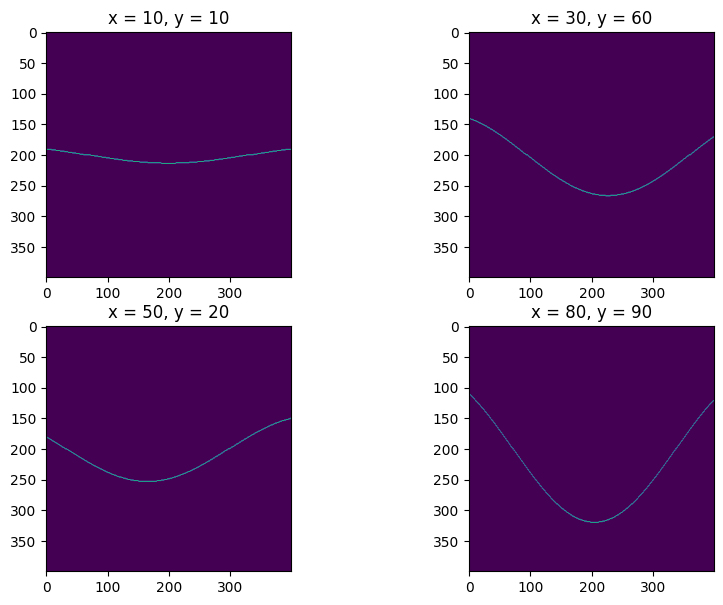

In [17]:
import math
def get_params(theta_bins, rho_bins, x, y):
    theta = np.linspace(-np.pi/2, np.pi, num=theta_bins)
    rho = np.array(x * np.cos(theta) + y * np.sin(theta))
    rho = rho.astype(np.int32)
    
    accumulator = np.zeros((rho_bins, theta_bins))
    
    for i in range(len(rho)):
        rho[i] += theta_bins/2
        accumulator[rho[i], i] += 1
    
    return accumulator

line1 = get_params(400, 400, 10, 10)
line2 = get_params(400, 400, 30, 60)
line3 = get_params(400, 400, 50, 20)
line4 = get_params(400, 400, 80, 90)

fig, ax = plt.subplots(2,2,figsize=(10,7))

ax[0,0].imshow(line1)
ax[0,0].set_title("x = 10, y = 10")

ax[0,1].imshow(line2)
ax[0,1].set_title("x = 30, y = 60")

ax[1,0].imshow(line3)
ax[1,0].set_title("x = 50, y = 20")

ax[1,1].imshow(line4)
ax[1,1].set_title("x = 80, y = 90")

b) Implement the function `hough_find_lines` that accepts a binary image, the number of bins for `ϑ` and `ρ` (allow the possibility of them being different) and a threshold. Create an accumulator matrix A for the parameter space `(ρ, ϑ)`. Parameter `ϑ` is defined in the interval from `−π/2` to `π/2`, `ρ` is defined on the interval from −D to
D, where D is the length of the image diagonal. For each nonzero pixel in the image, generate a curve in the `(ρ, ϑ)` space by using the equation 7 for all possible values of `ϑ` and increase the corresponding cells in A. Display the accumulator matrix. Test the method on your own synthetic images ((e.g. 100 × 100 black image, with two
white pixels at (10, 10) and (10, 20)). \
Finally, test your function on two synthetic images oneline.png and rectangle.png. First, you should obtain an edge map for each image using either your function findedges or some inbuilt function. Run your implementation of the Hough algorithm on the resulting edge maps.

In [140]:
def hough_find_lines(img, theta_bins, rho_bins, thresh=.1):
    accumulator = np.zeros((rho_bins, theta_bins))
    theta = np.linspace(-np.pi/2, np.pi/2, num=theta_bins)
    r = rho_bins / (2 * np.sqrt(theta_bins**2 + rho_bins**2))  
    print(img.shape)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            try:
                if img[i,j] <= thresh: continue
                rho = (j * np.cos(theta) + i * np.sin(theta)) * r + rho_bins / 2
                rho = rho.astype(np.uint32)
                for k in range(len(rho)):
                    accumulator[rho[k], k] += 1
    
            except IndexError:
                pass
    return accumulator    

(100, 100)
(288, 460)
(288, 460)


Text(0.5, 1.0, 'rectangle.png')

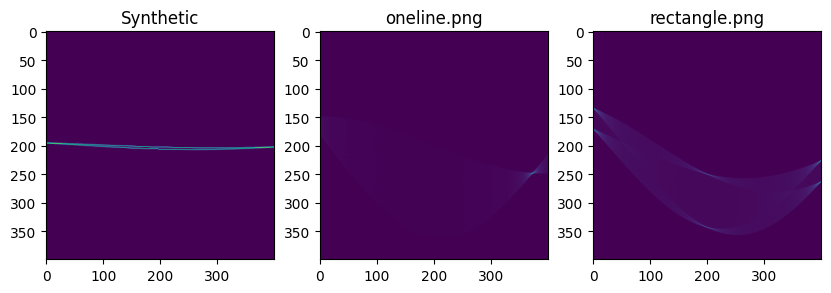

In [141]:
img0 = np.zeros((100, 100))
img0[10,10] = 1
img0[10,20] = 1
k = gaussian_kernel(3)
img0 = cv2.filter2D(img0, -1, k)

img1 = cv2.imread("images/oneline.png")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img1 = cv2.Canny(img1, 50, 100)

img2 = cv2.imread("images/rectangle.png")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2 = cv2.Canny(img2, 50, 100)

theta_bins, rho_bins = 400, 400

img0 = hough_find_lines(img0, theta_bins, rho_bins)
img1 = hough_find_lines(img1, theta_bins, rho_bins)
img2 = hough_find_lines(img2, theta_bins, rho_bins)

fig, ax = plt.subplots(1,3,figsize=(10,7))

ax[0].imshow(img0)
ax[0].set_title("Synthetic")

ax[1].imshow(img1)
ax[1].set_title("oneline.png")

ax[2].imshow(img2)
ax[2].set_title("rectangle.png")


c) The sinusoids don’t usually intersect in only one point, resulting in more than one detected line. Implement a function named nonmaxima_suppression_box that checks the neighborhood of each pixel and set it to 0 if it is not the maximum value in the neighborhood (only consider 8-neighborhood). If more neighbouring pixels have the
maximum value, keep only one.

In [142]:
def nonmaxima_suppression_box(accumulator):
    img = accumulator
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            neighborhood = [img[i-1,j-1], img[i-1,j], img[i-1, j+1],
                       img[i,j-1], img[i,j+1], 
                       img[i+1,j-1], img[i+1,j], img[i+1,j+1]]
            
            # Check if its the strongest
            if np.max(neighborhood) > img[i,j]:
                # Remove multiple maximums
                if np.max(neighborhood) == img[i,j]:
                    np.where(neighborhood == img[i,j], 0, img[i,j])
                
                img[i,j] = 0
    return img
            

d) Search the parameter space and extract all the parameter pairs (ρ, ϑ) whose corresponding accumulator cell value is greater than a specified threshold threshold. Draw the lines that correspond to the parameter pairs using the `draw_line` function that you can find in the supplementary material.

(100, 100)


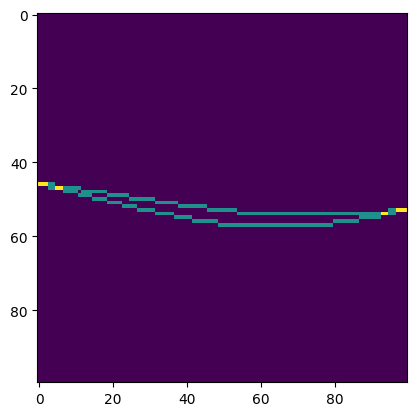

In [143]:
img_synthetic_orig = np.zeros((100,100)).astype(np.uint8)
img_synthetic_orig[10, 10] = 1
img_synthetic_orig[10, 20] = 1
k = gaussian_kernel(3)
img_synthetic = cv2.filter2D(img_synthetic_orig, -1, k)
img_synthetic = hough_find_lines(img_synthetic_orig, 100, 100, .5)

plt.imshow(img_synthetic)

(288, 460)
460.0


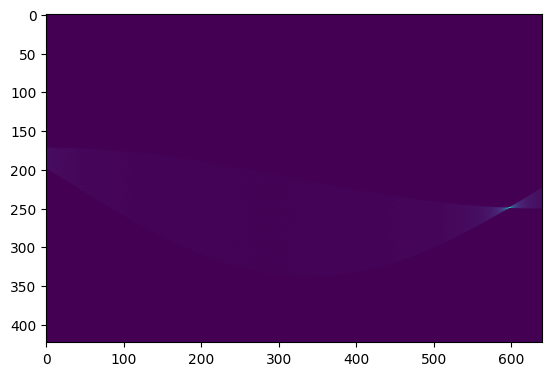

In [144]:
img_line_orig = cv2.imread('images/oneline.png')
img_line = cv2.cvtColor(img_line_orig, cv2.COLOR_BGR2GRAY)
img_line = cv2.Canny(img_line, 50, 100)
#img_line = findedges(img_line, 3, .4)
img_line = hough_find_lines(img_line, img.shape[1], img.shape[0],  0.2)
#img_line = nonmaxima_suppression_box(img_line)
plt.imshow(img_line)
print(np.max(img_line))

(288, 460)


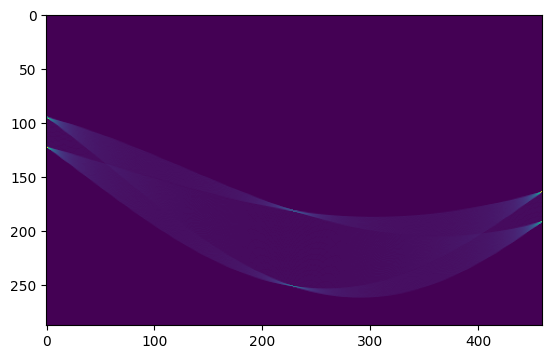

In [145]:
img_rectangle_orig = cv2.imread('images/rectangle.png')
img_rectangle = cv2.cvtColor(img_rectangle_orig, cv2.COLOR_BGR2GRAY)
img_rectangle = cv2.Canny(img_rectangle, 50, 200)
h, w = img_rectangle.shape
img_rectangle = hough_find_lines(img_rectangle, w, h, 0.3)
plt.imshow(img_rectangle)
#img_rectangle = nonmaxima_suppression_box(img_rectangle)

In [188]:
from a3_utils import *

def hough_to_spatial(img, theta_bins, rho_bins, thresh, draw=True):

    diag = np.sqrt(rho_bins**2 + theta_bins**2)
    pairs = np.where(img > thresh)
    pairs = np.array(list(zip(pairs[0], pairs[1])))
    
    if not draw:
        while len(pairs) > 10:
            pairs = np.where(img > thresh)
            pairs = np.array(list(zip(pairs[0], pairs[1])))
            thresh += 1

    
    all_pairs = []
    
    for pair in pairs:
        rho, theta = pair[0], pair[1]
        rho_spatial = (rho - rho_bins/2) * ((2 * diag) / rho_bins)
        theta_spatial = theta / theta_bins * np.pi - np.pi/2
         
        all_pairs.append((rho_spatial, theta_spatial))
        
        if (draw):
            draw_line(rho_spatial, theta_spatial, img.shape[0], img.shape[1])
            
    return all_pairs
        

0.02 2.0


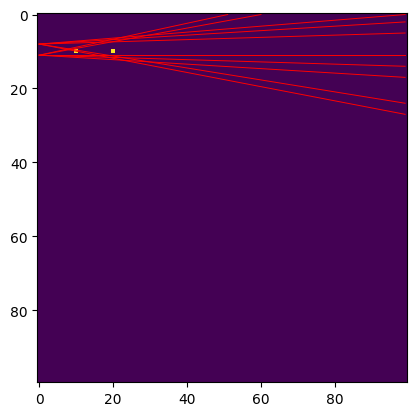

In [147]:
print(np.mean(img_synthetic), np.max(img_synthetic))
#plt.imshow(img_synthetic)
hough_to_spatial(img_synthetic, img_synthetic.shape[1], img_synthetic.shape[0], 1.5)
plt.imshow(img_synthetic_orig)

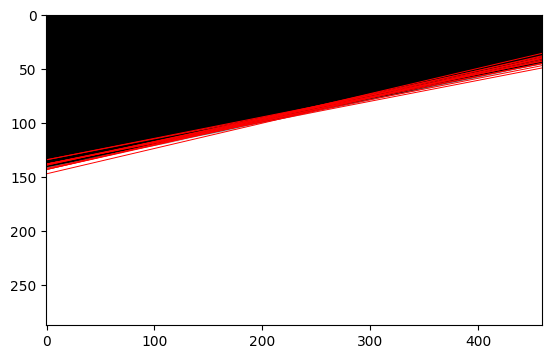

In [148]:
img_rectangle = nonmaxima_suppression_box(img_rectangle)

hough_to_spatial(img_line, img_line.shape[1], img_line.shape[0], 160)
plt.imshow(img_line_orig)



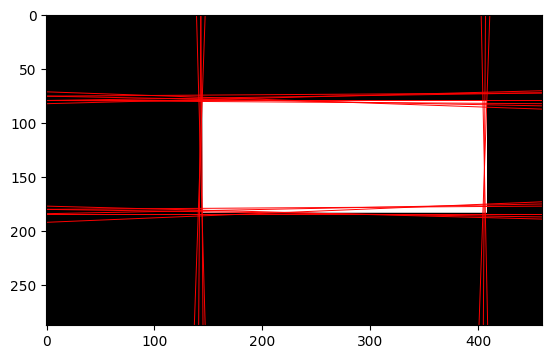

In [149]:
hough_to_spatial(img_rectangle, img_rectangle.shape[1], img_rectangle.shape[0], 100)
plt.imshow(img_rectangle_orig)


e) Read the image from files `bricks.jpg` and `pier.jpg`. Change the image to grayscale and detect edges. Then detect lines using your algorithm. As the results will likely depend on the number of pixels that vote for specific cell and this depends on the size of the image and the resolution of the accumulator, try sorting the pairs by
their corresponding cell values in descending order and only select the top n = 10 lines. Display the results and experiment with parameters of Hough algorithm as well as the edge detection algorithm, e.g. try changing the number of cells in the accumulator or σ parameter in edge detection to obtain results that are similar or
better to the ones shown on the image below.

In [246]:
bricks_orig = cv2.imread("images/bricks.jpg")
pier_orig = cv2.imread("images/pier.jpg")
bricks = cv2.cvtColor(bricks_orig, cv2.COLOR_BGR2GRAY).astype(np.uint8)
pier = cv2.cvtColor(pier_orig, cv2.COLOR_BGR2GRAY).astype(np.uint8)


bricks = cv2.Canny(bricks, 70, 200)
pier = cv2.Canny(pier, 70, 150)

#r2 = hough_find_lines(pier, pier.shape[1], pier.shape[0], 100)


(426, 640)


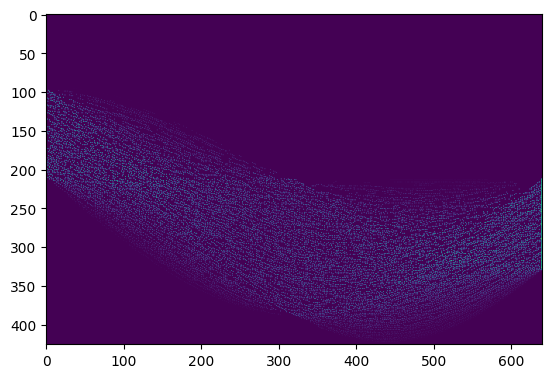

In [255]:
# BRICKS
r1 = hough_find_lines(bricks.astype(np.float64)/255, 640, 426, .9)
r1 = nonmaxima_suppression_box(r1)
pairs = hough_to_spatial(r1, 640, 426, 100, False)
plt.imshow(r1)


10


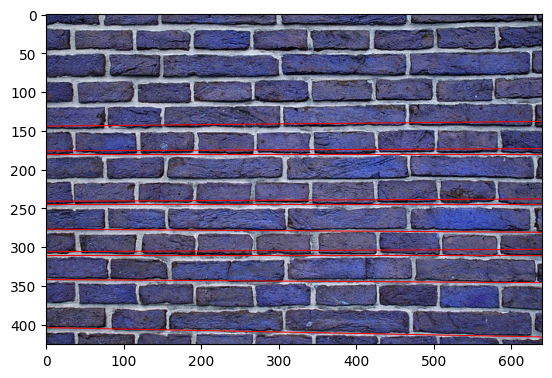

In [256]:

print(len(pairs))
for pair in pairs:
    #draw_line(pair[0], pair[1], bricks_orig.shape[0], bricks_orig.shape[1])
    draw_line(pair[0], pair[1], 426, 640)
    
plt.imshow(bricks_orig)

(426, 640)


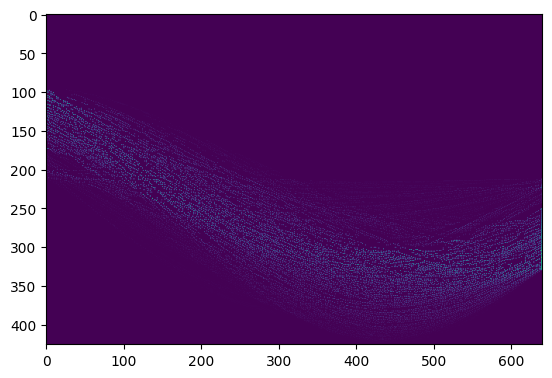

In [260]:
r2 = hough_find_lines(pier.astype(np.float64)/255, 640, 426, .9)
r2 = nonmaxima_suppression_box(r2)
pairs = hough_to_spatial(r2, 640, 426, 100, False)
plt.imshow(r2)

9


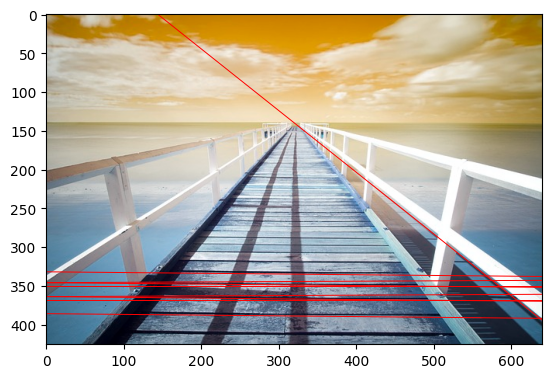

In [261]:
print(len(pairs))
for pair in pairs:
    #draw_line(pair[0], pair[1], bricks_orig.shape[0], bricks_orig.shape[1])
    draw_line(pair[0], pair[1], 426, 640)
plt.imshow(pier_orig)    